In [0]:
#CHECK THE CONTENT OF THE DBFS
dbutils.fs.ls("/FileStore/tables")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709126412000),
 FileInfo(path='dbfs:/FileStore/tables/account-model/', name='account-model/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1706712567000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-2.zip', name='accounts-2.zip', size=5297592, modificationTime=1706974309000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706712510000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activat

In [0]:
#remove clinical trial csv should in case it is available
dbutils.fs.rm("/FileStore/tables/clinicaltrial_2023.csv")
#declare a variable called fileroot
fileroot = "clinicaltrial_2023"
# copy the file to the local cluster to unzip the file
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")

Out[2]: True

In [0]:
import os
os.environ['fileroot'] = fileroot

In [0]:
%sh
# Check if the CSV file exists
if [ -f "/tmp/${fileroot}.csv" ]; then
    # If the CSV file exists, remove it
    rm "/tmp/${fileroot}.csv"
fi
 
# Unzip the ZIP file
unzip -d "/tmp" "/tmp/${fileroot}.zip"

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  


In [0]:
dbutils.fs.cp("file:/tmp/" + fileroot + ".csv", "/FileStore/tables")

Out[5]: True

In [0]:
#Exploring the data
dbutils.fs.head("/FileStore/tables/" + fileroot+ ".csv")

[Truncated to first 65536 bytes]
Out[6]: '"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\r\n"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-

In [0]:
#THIS COMMAND HELP TO READ THE CSV FILE AS AN RDD
myRDD1= sc.textFile("FileStore/tables/clinicaltrial_2023.csv")

In [0]:
#THIS COMMAND ASSISTS IN DEFINING A FUNCTION DEDICATED TO CLEANING AND TRANSFORMING INDIVIDUAL ROWS WITHIN THE CLINICALTRIAL DATASET
def clean_and_transform(row):
    #THIS AIDS IN ELIMINATING SURPLUS TRAILING COMMAS AND UNNECESARY DOUBLE QUOTES THROUGH THE UTILIZATION OF THE STRIP METHOD.
    cleaned_row = row.strip(",").strip('"')
    #THIS COMMAND FACILITATES THE SPLITTING OF THE ROW BY THE SPECIFIED DELIMITER, WHICH IN THIS CASE IS THE TAB ('\t').
    cleaned_row = cleaned_row.split('\t')

    return cleaned_row

# RDD containing rows with varying column lengths
 
def fill_empty_columns(row):
    # Check if the row has less than 14 columns
    if len(row) < 14:
        # Fill up the remaining columns with empty strings
        row += [''] * (14 - len(row))
    return row
 


In [0]:
#THIS COMMAND MAP THE CLEAN_AND_TRANSFORM FUNCTION TO myRDD2.
myRDD2 = myRDD1.map(clean_and_transform) \
       .map(fill_empty_columns)\
      .zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])

myRDD2.take(5)

Out[9]: [['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  '',
  'RECRUITING',
  'Cerebrovascular Function|Cognition',
  'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
  'McMaster University',
  'Alzheimer\'s Society of Brant", Haldimand Norfolk," Hamilton Halton',
  '30.0',
  'OTHER',
  'INTERVENTION

In [0]:
# Function to replace empty strings with None
def replace_empty_with_null(line):
    return [None if field == "" else field for field in line]
 
# Replace empty fields with null values
replace_with_null = myRDD2.map(replace_empty_with_null)

In [0]:
def clean_date(date):
    if len(date) < 8:
        date = date + "-01"
    return date
 
def fill_empty_date(date, default_value):
    return default_value if not date else date
 
# Select the column indices
column_indices = [12, 13]
 
# Clean up the start and completion dates
default_date = "2024-01-01"
 
# First RDD: Fill up empty date columns
myRDD3 = replace_with_null.map(lambda row: [
    fill_empty_date(row[i], default_date) if i in column_indices else row[i] for i in range(len(row))
])
 
# Second RDD: Format the date columns
myRDD4 = myRDD3.map(lambda row: [
    clean_date(row[i]) if i in column_indices else row[i] for i in range(len(row))
])
 
myRDD4.take(5)

Out[11]: [['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  None,
  'RECRUITING',
  'Cerebrovascular Function|Cognition',
  'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
  'McMaster University',
  'Alzheimer\'s Society of Brant", Haldimand Norfolk," Hamilton Halton',
  '30.0',
  'OTHER',
  'INTERVENT

In [0]:
#Q1 IMPLEMENTATION IN RDD
 
# Extract Id
Id_rdd =myRDD4.map(lambda x: x[0])
 
# Count the total number of Id

distinct_Id = Id_rdd.distinct().count()
 
print("Number of Studies: ", distinct_Id)

Number of Studies:  483422


In [0]:
#Q2 IMPLEMENTATION IN RDD
# Extract 'Type' field and create key-value pairs
type_counts_rdd = myRDD4.map(lambda row: (row[10], 1))
 
# get the frequencies of reach type
type_frequency = type_counts_rdd.reduceByKey(lambda x, y: x + y)
 
# Sorting the result by frequency in descending order
sorted_frequencies = type_frequency.sortBy(lambda x: x[1], ascending=False)
 
sorted_frequencies.collect()

Out[13]: [('INTERVENTIONAL', 371382),
 ('OBSERVATIONAL', 110221),
 ('EXPANDED_ACCESS', 928),
 (None, 891)]

In [0]:
#Q3 IMPLEMENTATION IN RDD
# Step 1: Extract the 'Conditions' column
 
def split_string(text):
    if text and text != '':
        return text.split('|')
    return ''
 
conditions_rdd = myRDD4.map(lambda row: (row[0],row[4])).flatMap(lambda x: split_string(x[1])).map(lambda x: (x,1)).reduceByKey(lambda a,b: a+b)
sorted_rdd = conditions_rdd.sortBy(lambda x: x[1], ascending=False)
# filter_cond_rdd = conditions_rdd.filter(lambda x: x == '')
 
sorted_rdd.take(5)

Out[14]: [('Healthy', 9731),
 ('Breast Cancer', 7502),
 ('Obesity', 6549),
 ('Stroke', 4071),
 ('Hypertension', 4020)]

In [0]:
dbutils.fs.cp("/FileStore/tables/pharma.zip" , "file:/tmp/")


Out[15]: True

In [0]:
%sh

unzip -d /tmp/  /tmp/pharma.zip

ls /tmp

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         
Rserv
RtmpNjRxTb
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2023.csv
clinicaltrial_2023.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
pharma.csv
pharma.zip
python_lsp_logs
systemd-private-3891d71dc69a41b28fa0e0b7590fac3e-apache2.service-w44eof
systemd-private-3891d71dc69a41b28fa0e0b7590fac3e-ntp.service-VrhYPi
systemd-private-3891d71dc69a41b28fa0e0b7590fac3e-systemd-logind.service-jcG5bf
systemd-private-3891d71dc69a41b28fa0e0b7590fac3e-systemd-resolved.service-ErTKFi
tmp.vzs5N9GJcF


In [0]:
dbutils.fs.cp("file:/tmp/pharma.csv" , "/FileStore/tables")

Out[17]: True

In [0]:
pharma_rdd = sc.textFile("/FileStore/tables/pharma.csv") \
    .map(lambda line: line.split(",")) \
    .map(lambda row: [field.strip('"') for field in row]) \
    .map(lambda row: [field.strip() for field in row]) \
    .map(lambda x: x[1])

pharma_companies_rdd = pharma_rdd.distinct()
 

In [0]:
#Q4 IMPLEMEMTATION IN RDD
filtered_col = myRDD4.map(lambda x: x[6])
clinicalTrial_pairs = filtered_col.map(lambda x: (x, 1))
pharma_pairs = pharma_companies_rdd.map(lambda x: (x, 1))

join_rdd = clinicalTrial_pairs.leftOuterJoin(pharma_pairs)

filtered_rdd = join_rdd.filter(lambda x: x[1][1] is None)
result = filtered_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a,b: a+b)

result = result.map(lambda x: (x[1], x[0]))

result = result.sortByKey(False).take(10)

print(result)

[(3410, 'National Cancer Institute (NCI)'), (3335, 'Assiut University'), (3023, 'Cairo University'), (2951, 'Assistance Publique - Hôpitaux de Paris'), (2766, 'Mayo Clinic'), (2702, 'M.D. Anderson Cancer Center'), (2393, 'Novartis Pharmaceuticals'), (2340, 'National Institute of Allergy and Infectious Diseases (NIAID)'), (2263, 'Massachusetts General Hospital'), (2181, 'National Taiwan University Hospital')]


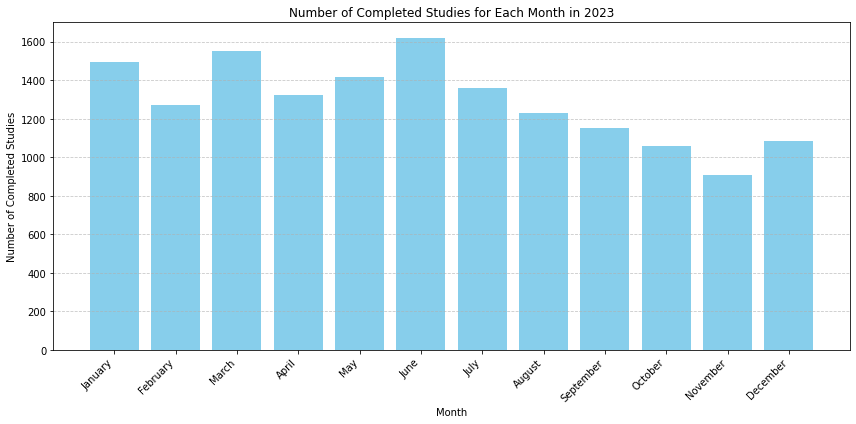

Month			Completed Studies
January                 1494
February                1272
March                   1552
April                   1324
May                     1415
June                    1619
July                    1360
August                  1230
September               1152
October                 1058
November                909
December                1082


In [0]:
#Q5 IMPLEMEMTATION IN RDD
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import calendar
 
completion_index = 13
# Function to parse completion date and count completed studies for each month
 
def count_completed_studies(row):
    completion_date = datetime.strptime(row[completion_index], '%Y-%m-%d')
    if row[3] == 'COMPLETED' and completion_date.year == 2023:
        return (completion_date.month, 1)
    else:
        return (0, 0)
 
filter_less_row = myRDD4.filter(lambda fields: len(fields) == 14)

filter_less_row.take(5)
 
# Count completed studies for each month
completed_studies_by_month = filter_less_row.map(count_completed_studies) \
                                .reduceByKey(lambda x, y: x + y) \
                                .collectAsMap()
 
# Plotting
months = range(1, 13)
study_counts = [completed_studies_by_month.get(month, 0) for month in months]
 
# Convert month numbers to month names
month_names = [calendar.month_name[month] for month in months]
 
plt.figure(figsize=(12, 6))
plt.bar(month_names, study_counts, color='skyblue')
plt.title('Number of Completed Studies for Each Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
 
# Table of values
print("Month\t\t\tCompleted Studies")
for month in range(1, 13):
    count = completed_studies_by_month.get(month, 0)
    print(f"{calendar.month_name[month]:<24}{count}")

In [0]:
#Further analysis 1

#extracting interventions and their frequencies 
interventions_rdd = myRDD2.map(lambda x: x[5])
interventions_rdd.take(10)


Out[21]: ["BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
 'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
 'DRUG: Insulin (tight blood glucose control)',
 'OTHER: SuperMELD',
 'OTHER: adherence support system based on a vocal assistant',
 'BEHAVIORAL: Person-centered inhibitory control training|BEHAVIORAL: Active behavioral response training',
 'DRUG: Propranolol|DRUG: Placebo',
 'BEHAVIORAL: Computerized brief alcohol intervention + IVR booster calls|BEHAVIORAL: Computerized brief alcohol intervention|BEHAVIORAL: Attention Control',
 'OTHER: Pharmacist - Smoking Cessation Support',
 'PROCEDURE: Biospecimen Collection|OTHER: Genetic Testing|OTHER: Medical Chart Review']

In [0]:
#remove empty column
interventions_rdd1 = interventions_rdd.filter(lambda x: x !='')
interventions_rdd1.take(10)

Out[29]: ["BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
 'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
 'DRUG: Insulin (tight blood glucose control)',
 'OTHER: SuperMELD',
 'OTHER: adherence support system based on a vocal assistant',
 'BEHAVIORAL: Person-centered inhibitory control training|BEHAVIORAL: Active behavioral response training',
 'DRUG: Propranolol|DRUG: Placebo',
 'BEHAVIORAL: Computerized brief alcohol intervention + IVR booster calls|BEHAVIORAL: Computerized brief alcohol intervention|BEHAVIORAL: Attention Control',
 'OTHER: Pharmacist - Smoking Cessation Support',
 'PROCEDURE: Biospecimen Collection|OTHER: Genetic Testing|OTHER: Medical Chart Review']

In [0]:
#split by comma
interventions_rdd2 = interventions_rdd1.flatMap(lambda x: x.split(","))
interventions_rdd2.take(10)

Out[30]: ["BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
 'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
 'DRUG: Insulin (tight blood glucose control)',
 'OTHER: SuperMELD',
 'OTHER: adherence support system based on a vocal assistant',
 'BEHAVIORAL: Person-centered inhibitory control training|BEHAVIORAL: Active behavioral response training',
 'DRUG: Propranolol|DRUG: Placebo',
 'BEHAVIORAL: Computerized brief alcohol intervention + IVR booster calls|BEHAVIORAL: Computerized brief alcohol intervention|BEHAVIORAL: Attention Control',
 'OTHER: Pharmacist - Smoking Cessation Support',
 'PROCEDURE: Biospecimen Collection|OTHER: Genetic Testing|OTHER: Medical Chart Review']

In [0]:
#split by  pipe
interventions_rdd3 = interventions_rdd2.flatMap(lambda x: x.split("|"))
interventions_rdd3.take(10)

Out[31]: ["BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention",
 'BEHAVIORAL: Enhanced usual care',
 'OTHER: Placebo',
 'DIETARY_SUPPLEMENT: β-OHB',
 'DRUG: Insulin (tight blood glucose control)',
 'OTHER: SuperMELD',
 'OTHER: adherence support system based on a vocal assistant',
 'BEHAVIORAL: Person-centered inhibitory control training',
 'BEHAVIORAL: Active behavioral response training',
 'DRUG: Propranolol']

In [0]:
#pair rdd to count the frequency 
interventions_rdd4 = interventions_rdd3.map(lambda c: (c, 1))
interventions_rdd4.take(10)

Out[32]: [("BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention", 1),
 ('BEHAVIORAL: Enhanced usual care', 1),
 ('OTHER: Placebo', 1),
 ('DIETARY_SUPPLEMENT: β-OHB', 1),
 ('DRUG: Insulin (tight blood glucose control)', 1),
 ('OTHER: SuperMELD', 1),
 ('OTHER: adherence support system based on a vocal assistant', 1),
 ('BEHAVIORAL: Person-centered inhibitory control training', 1),
 ('BEHAVIORAL: Active behavioral response training', 1),
 ('DRUG: Propranolol', 1)]

In [0]:
#reduce by key to sum up the values
interventions_rdd5 = interventions_rdd4.reduceByKey(lambda x,y: x+y)
interventions_rdd5.take(10)

Out[33]: [('BEHAVIORAL: Enhanced usual care', 25),
 ('BEHAVIORAL: Attention Control', 66),
 ('OTHER: Pharmacist - Smoking Cessation Support', 1),
 ('OTHER: Blood draw', 86),
 ('BEHAVIORAL: 5waysA Inactive wait-list control', 1),
 ('DRUG: human fetal-derived Neural Stem Cells (hNSCs)', 1),
 ('DRUG: PREDNISOLONE', 1),
 ('PROCEDURE: Doing Different ICU techniques and skills', 1),
 ('DEVICE: rTMS', 107),
 ('OTHER: Intra-abdominal pressure during laparoscopy', 1)]

In [0]:
# Split each intervention by ":" and extract the intervention type
interventions_rdd5_cleaned = interventions_rdd5.map(lambda x: (x[0].split(":")[0].strip(), x[1]))

# Aggregate the counts for each intervention type
interventions_rdd5_aggregated = interventions_rdd5_cleaned.reduceByKey(lambda x, y: x + y)

# Sort the aggregated interventions by count in descending order
interventions_rdd5_sorted = interventions_rdd5_aggregated.sortBy(lambda x: x[1], ascending=False)

# Take the first 20 interventions after aggregation and sorting
interventions_rdd6 = interventions_rdd5_sorted.take(10)

# Display the top 20 interventions
interventions_rdd6 


Out[34]: [('DRUG', 353617),
 ('OTHER', 135985),
 ('DEVICE', 81400),
 ('BEHAVIORAL', 74219),
 ('PROCEDURE', 71472),
 ('BIOLOGICAL', 40817),
 ('DIETARY_SUPPLEMENT', 24422),
 ('DIAGNOSTIC_TEST', 19660),
 ('RADIATION', 10937),
 ('GENETIC', 3557)]

In [0]:
# Swap the positions of count and intervention type
interventions_top_10 = [(count, intervention) for intervention, count in interventions_rdd6]

# Display the top 20 interventions with count first
interventions_top_10


Out[35]: [(353617, 'DRUG'),
 (135985, 'OTHER'),
 (81400, 'DEVICE'),
 (74219, 'BEHAVIORAL'),
 (71472, 'PROCEDURE'),
 (40817, 'BIOLOGICAL'),
 (24422, 'DIETARY_SUPPLEMENT'),
 (19660, 'DIAGNOSTIC_TEST'),
 (10937, 'RADIATION'),
 (3557, 'GENETIC')]